In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from models import SimpleRNN, LSTM
#from lstm_models import LSTM
import utils_2 as ut2
from traindata import trainData



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

sns.set_style("darkgrid")


import numpy as np
from tqdm import tqdm



np.random.seed(seed=77)

## **data**

In [2]:
#fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fpath ='/Users/falconlab/Documents/GitHub/Tesis/data/low/'
fname = "file1_080124.mat"
#cutoff = [8/1000, 11/1000]

data = trainData(fpath, fname, 'Amplitude')
train, val, test = data.split_data('Amplitude')

0         0.006094
1         0.006132
2         0.006056
3         0.006018
4         0.006170
            ...   
599995    0.007766
599996    0.007741
599997    0.007761
599998    0.007748
599999    0.007755
Name: Amplitude, Length: 600000, dtype: float64
0         0.006094
1         0.006132
2         0.006056
3         0.006018
4         0.006170
            ...   
599995    0.007766
599996    0.007741
599997    0.007761
599998    0.007748
599999    0.007755
Name: Amplitude, Length: 600000, dtype: float64
0         0.006094
1         0.006132
2         0.006056
3         0.006018
4         0.006170
            ...   
599995    0.007766
599996    0.007741
599997    0.007761
599998    0.007748
599999    0.007755
Name: Amplitude, Length: 600000, dtype: float64
0         0.006094
1         0.006132
2         0.006056
3         0.006018
4         0.006170
            ...   
599995    0.007766
599996    0.007741
599997    0.007761
599998    0.007748
599999    0.007755
Name: Amplitude, Len

In [3]:
# sub sampleo

train = utils.subsample(train, 2)
val = utils.subsample(val, 2)
test = utils.subsample(test, 2)

In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
val_scaled = scaler.transform(val.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [5]:
x_train, y_train = ut2.create_sequences(train_scaled, 1000, 1)
x_train = x_train.squeeze()
y_train = y_train.squeeze()

x_val, y_val = ut2.create_sequences(val_scaled, 1000, 1)
x_val = x_val.squeeze()
y_val = y_val.squeeze()

x_test, y_test = ut2.create_sequences(test_scaled[:3000], 1000, 1)
x_test = x_test.squeeze()
y_test = y_test.squeeze()

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((209000, 1000), (209000,), (44000, 1000), (44000,), (2000, 1000), (2000,))

## **Gradient Boosting**

In [6]:
model = HistGradientBoostingRegressor()
param = {'learning_rate': [0.01, 0.1, 1],
         'loss': ['squared_error', 'absolute_error', 'gamma', 'poisson'],
         'min_samples_leaf': [10, 20, 30],
         'scoring' : ['neg_mean_squared_error', 'neg_mean_percentage_absolute_error', 'neg_mean_absolute_error']
         }

test_fold = [-1 for _ in range(x_train[:5000].shape[0])] + [0 for _ in range(x_val[:2000].shape[0])]
ps = PredefinedSplit(test_fold)

#concateno matrices de training y validación
xTrainVal = np.concatenate((x_train[:5000],x_val[:2000]),axis=0)
yTrainVal = np.concatenate((y_train[:5000],y_val[:2000]),axis = 0)


grid=GridSearchCV(model, param, n_jobs = -1, verbose = 2)
grid.fit(xTrainVal,yTrainVal)

print('Mejor Estimator: ', grid.best_estimator_)
print('Mejores Parametros: ', grid.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_squared_error; total time=  40.3s
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_squared_error; total time=  41.0s
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_squared_error; total time=  42.2s
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_squared_error; total time=  42.8s
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_percentage_absolute_error; total time=  42.8s
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_percentage_absolute_error; total time=  44.7s
[CV] END learning_rate=0.01, loss=squared_error, min_samples_leaf=10, scoring=neg_mean_percentage_absolute_error; total time=  43.2s
[CV] END learning_rate=0.01, loss=squared_error, min_s

In [7]:
model = grid.best_estimator_

In [8]:
model.fit(x_train, y_train)

HistGradientBoostingRegressor(loss='poisson', min_samples_leaf=10,
                              scoring='neg_mean_squared_error')

In [9]:
import pickle
# save the model to disk
filename = 'GBHist_model.sav'
pickle.dump(model, open(filename, 'wb'))

## **testeo**

In [10]:
def rollingWindowPrediction_SVR(model, x_test, steps=50):
    output = []
    N = x_test.shape[-1]

    for elem in tqdm(x_test):
        elem = elem.reshape(1, -1)
        #print(elem)
        test_aux = []
        count = 0
        while count < steps:
            #print(count)
            pred = model.predict(elem)
            test_aux.append(pred[0])
            elem = np.append(elem, pred)[1:].reshape(1,-1)
            #print(elem.shape)
            count += 1

        output.append(test_aux)
    return output

In [12]:
import pickle
filename = 'GBHist_model.sav'
# load model
model = pickle.load(open(filename, 'rb'))

In [13]:
test_pred = rollingWindowPrediction_SVR(model, x_test, steps = 50)

100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]


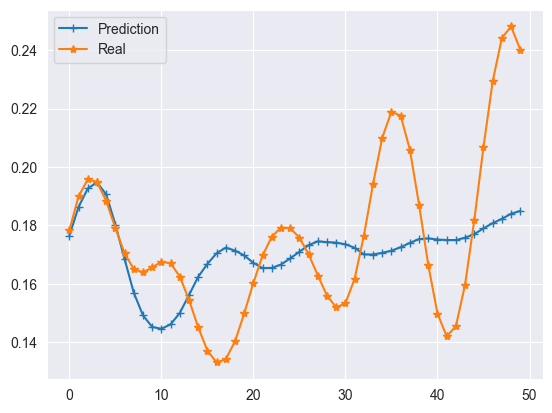

In [14]:
i = 65

plt.plot(test_pred[i],'-+', label='Prediction')
plt.plot(y_test[i:i+50], '-*',label='Real')
plt.legend()
plt.show()